# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../Yang_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
df_initial = df_initial.drop(columns=['SRR7542855_sorted.bam', 'SRR7542856_sorted.bam', 'SRR7542857_sorted.bam',
                                      'SRR7542858_sorted.bam', 'SRR7542859_sorted.bam', 'SRR7542860_sorted.bam',
                                      'SRR7542861_sorted.bam', 'SRR7542862_sorted.bam', 'SRR7542863_sorted.bam'])
metadata = pd.read_csv(metaPath)
metadata = metadata.drop([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [4]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR7542872_sorted.bam,SRR7542865_sorted.bam,SRR7542867_sorted.bam,SRR7542866_sorted.bam,SRR7542868_sorted.bam,SRR7542869_sorted.bam,SRR7542870_sorted.bam,SRR7542864_sorted.bam,SRR7542871_sorted.bam
Geneid,,,,,,,,,,,,,,
gene-AUO97_RS00010,NZ_CP018664.1,1277,2113,+,837,9,20,9,4,15,9,3,25,3
gene-AUO97_RS00015,NZ_CP018664.1,2164,2769,+,606,4,11,8,5,16,5,2,17,1
gene-AUO97_RS00020,NZ_CP018664.1,3336,3662,+,327,23,91,91,49,104,43,20,147,16
gene-AUO97_RS00025,NZ_CP018664.1,3659,4129,-,471,20,61,26,38,33,17,17,67,12
gene-AUO97_RS00030,NZ_CP018664.1,4293,4655,-,363,746,1866,1406,1039,1644,908,747,2437,530


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,treatment
9,SRR7542864,RNA-Seq,300,1729560600,PRJNA481979,SAMN09692911,536396681,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409233,GSM3293813,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:37:00Z,1,GSM3293813,"AB1 and Abp1 lysates\, 5min\, replicate 1",SRP154466,Abp1,after phage infection of 5min
10,SRR7542865,RNA-Seq,300,1637107200,PRJNA481979,SAMN09692910,507587738,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409234,GSM3293814,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:40:00Z,1,GSM3293814,"AB1 and Abp1 lysates\, 5min\, replicate 2",SRP154466,Abp1,after phage infection of 5min
11,SRR7542866,RNA-Seq,300,1726344600,PRJNA481979,SAMN09692909,529118492,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409235,GSM3293815,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:37:00Z,1,GSM3293815,"AB1 and Abp1 lysates\, 5min\, replicate 3",SRP154466,Abp1,after phage infection of 5min
12,SRR7542867,RNA-Seq,300,1752104700,PRJNA481979,SAMN09692908,546438876,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409236,GSM3293816,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:38:00Z,1,GSM3293816,"AB1 and Abp1 lysates\, 10min\, replicate 1",SRP154466,Abp1,after phage infection of 10min
13,SRR7542868,RNA-Seq,300,2262702600,PRJNA481979,SAMN09692907,702497704,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409237,GSM3293817,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:39:00Z,1,GSM3293817,"AB1 and Abp1 lysates\, 10min\, replicate 2",SRP154466,Abp1,after phage infection of 10min
14,SRR7542869,RNA-Seq,300,1933344600,PRJNA481979,SAMN09692906,600119711,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409238,GSM3293818,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:38:00Z,1,GSM3293818,"AB1 and Abp1 lysates\, 10min\, replicate 3",SRP154466,Abp1,after phage infection of 10min
15,SRR7542870,RNA-Seq,300,2186227500,PRJNA481979,SAMN09692905,689625094,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409239,GSM3293819,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:38:00Z,1,GSM3293819,"AB1 and Abp1 lysates\, 20min\, replicate 1",SRP154466,Abp1,after phage infection of 20min
16,SRR7542871,RNA-Seq,300,1773457200,PRJNA481979,SAMN09692904,561902733,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409240,GSM3293820,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:39:00Z,1,GSM3293820,"AB1 and Abp1 lysates\, 20min\, replicate 2",SRP154466,Abp1,after phage infection of 20min
17,SRR7542872,RNA-Seq,300,1876975200,PRJNA481979,SAMN09692903,601919231,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409241,GSM3293821,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:40:00Z,1,GSM3293821,"AB1 and Abp1 lysates\, 20min\, replicate 3",SRP154466,Abp1,after phage infection of 20min


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM3293813': '5_R1', 'GSM3293814': '5_R2', 'GSM3293815': '5_R3',
              'GSM3293816': '10_R1', 'GSM3293817': '10_R2', 'GSM3293818': '10_R3',
              'GSM3293819': '20_R1', 'GSM3293820': '20_R2', 'GSM3293821': '20_R3'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,treatment
9,SRR7542864,RNA-Seq,300,1729560600,PRJNA481979,SAMN09692911,536396681,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409233,GSM3293813,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:37:00Z,1,GSM3293813,"AB1 and Abp1 lysates\, 5min\, replicate 1",SRP154466,Abp1,after phage infection of 5min


In [9]:
metadataFull.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR7542864_sorted.bam,SRR7542864,RNA-Seq,300,1729560600,PRJNA481979,SAMN09692911,536396681,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409233,GSM3293813,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage Abp1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:37:00Z,1,GSM3293813,"AB1 and Abp1 lysates\, 5min\, replicate 1",SRP154466,Abp1,after phage infection of 5min,SRR7542864_sorted.bam,5_R1


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '20_R1', '20_R2', '20_R3']]
df

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3
Geneid,,,,,,,,,
gene-AUO97_RS00010,25,20,4,9,15,9,3,3,9
gene-AUO97_RS00015,17,11,5,8,16,5,2,1,4
gene-AUO97_RS00020,147,91,49,91,104,43,20,16,23
gene-AUO97_RS00025,67,61,38,26,33,17,17,12,20
gene-AUO97_RS00030,2437,1866,1039,1406,1644,908,747,530,746
...,...,...,...,...,...,...,...,...,...
gene-M172_gp50,1130,1463,393,8753,13459,6350,87880,75420,16519
gene-M172_gp51,728,847,239,5648,7968,4011,54416,46931,9921
gene-M172_gp52,2102,2339,637,15761,24769,14444,163469,134817,32191


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_021316.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_021316.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
3770,NC_021316.1,RefSeq,gene,874.0,1080.0,.,+,.,gene-M172_gp01,M172_gp01,Gene,protein_coding,M172_gp01,gene-M172_gp01,hypothetical protein,hypothetical protein,10124.0,unknown function
3771,NC_021316.1,RefSeq,gene,1510.0,1791.0,.,+,.,gene-M172_gp02,M172_gp02,Gene,protein_coding,M172_gp02,gene-M172_gp02,hypothetical protein,hypothetical protein,35847.0,unknown function
3772,NC_021316.1,RefSeq,gene,1863.0,2372.0,.,+,.,gene-M172_gp03,M172_gp03,Gene,protein_coding,M172_gp03,gene-M172_gp03,hypothetical protein,hypothetical protein,1448.0,unknown function
3773,NC_021316.1,RefSeq,gene,2374.0,2748.0,.,+,.,gene-M172_gp04,M172_gp04,Gene,protein_coding,M172_gp04,gene-M172_gp04,hypothetical protein,hypothetical protein,6323.0,unknown function
3774,NC_021316.1,RefSeq,gene,2846.0,3079.0,.,+,.,gene-M172_gp05,M172_gp05,Gene,protein_coding,M172_gp05,gene-M172_gp05,hypothetical protein,hypothetical protein,4445.0,unknown function
3775,NC_021316.1,RefSeq,gene,3154.0,3750.0,.,+,.,gene-M172_gp06,M172_gp06,Gene,protein_coding,M172_gp06,gene-M172_gp06,hypothetical protein,hypothetical protein,7131.0,unknown function
3776,NC_021316.1,RefSeq,gene,3738.0,3926.0,.,+,.,gene-M172_gp07,M172_gp07,Gene,protein_coding,M172_gp07,gene-M172_gp07,hypothetical protein,hypothetical protein,38792.0,unknown function
3777,NC_021316.1,RefSeq,gene,3907.0,4023.0,.,+,.,gene-M172_gp08,M172_gp08,Gene,protein_coding,M172_gp08,gene-M172_gp08,hypothetical protein,hypothetical protein,9054.0,unknown function
3778,NC_021316.1,RefSeq,gene,4182.0,4580.0,.,+,.,gene-M172_gp09,M172_gp09,Gene,protein_coding,M172_gp09,gene-M172_gp09,hypothetical protein,hypothetical protein,6769.0,unknown function
3779,NC_021316.1,RefSeq,gene,4651.0,5139.0,.,+,.,gene-M172_gp10,M172_gp10,Gene,protein_coding,M172_gp10,gene-M172_gp10,hypothetical protein,hypothetical protein,6421.0,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NZ_CP018664.1', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [14]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3
Geneid,,,,,,,,,
gene-AUO97_RS09875,2563,1938,2329,636,710,1568,418,359,1291
gene-AUO97_RS02075,102,109,69,38,39,24,14,7,25
gene-AUO97_RS09240,549,408,189,145,169,95,74,45,81
gene-AUO97_RS12025,0,5,2,1,2,1,0,0,3
gene-AUO97_RS18955,335,242,128,85,75,106,35,41,76
...,...,...,...,...,...,...,...,...,...
gene-AUO97_RS14440,165,125,69,101,95,51,21,22,26
gene-AUO97_RS02990,250,195,117,86,109,69,37,33,66
gene-AUO97_RS17825,311,242,191,134,155,88,29,21,73


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [15]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [16]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-AUO97_RS09875,104.644346,76.948483,76.577295,23.368055,20.503436,46.679640,15.652114,16.810298,42.607841,host,gene-AUO97_RS09875
gene-AUO97_RS02075,30.293181,31.469290,16.540959,10.233483,8.252741,5.278951,3.926306,2.539080,6.090793,host,gene-AUO97_RS02075
gene-AUO97_RS09240,110.727958,80.044862,30.750605,26.369039,24.145678,14.029865,13.754378,10.502557,13.272718,host,gene-AUO97_RS09240
gene-AUO97_RS12025,0.042140,0.450755,0.169676,0.113700,0.148952,0.092168,0.038609,0.048271,0.238401,host,gene-AUO97_RS12025
gene-AUO97_RS18955,29.510343,20.741745,9.102061,6.763781,4.694710,6.829547,2.860917,4.181421,5.438208,host,gene-AUO97_RS18955
...,...,...,...,...,...,...,...,...,...,...,...
gene-AUO97_RS14440,22.927690,16.906660,7.753574,12.646491,9.352889,5.201517,2.728952,3.570581,2.967022,host,gene-AUO97_RS14440
gene-AUO97_RS02990,216.331886,164.176645,81.715706,67.184739,66.850866,43.758068,29.671478,33.139937,46.413800,host,gene-AUO97_RS02990
gene-AUO97_RS17825,69.743724,52.797169,34.527944,27.083893,24.612605,14.446109,6.051516,5.514163,13.299861,host,gene-AUO97_RS17825


In [17]:
# Check gene names unique
len(tpms['Symbol'].unique())

3806

Log2+1 normalization tpms

In [18]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-AUO97_RS09875,6.723072,6.284449,6.277563,4.606919,4.426495,5.575301,4.057633,4.154640,5.446516,host,gene-AUO97_RS09875
gene-AUO97_RS02075,4.967776,5.021004,4.132656,3.489733,3.209881,2.650524,2.300506,1.823374,2.825947,host,gene-AUO97_RS02075
gene-AUO97_RS09240,6.803846,6.340649,4.988712,4.774473,4.652239,3.909760,3.883071,3.523883,3.835188,host,gene-AUO97_RS09240
gene-AUO97_RS12025,0.059549,0.536804,0.226109,0.155360,0.200319,0.127194,0.054653,0.068012,0.308478,host,gene-AUO97_RS12025
gene-AUO97_RS18955,4.931227,4.442396,3.336578,2.956760,2.509622,2.968929,1.948943,2.373348,2.686659,host,gene-AUO97_RS18955
...,...,...,...,...,...,...,...,...,...,...,...
gene-AUO97_RS14440,4.580609,4.162424,3.129872,3.770458,3.371962,2.632621,1.898770,2.192378,1.988057,host,gene-AUO97_RS14440
gene-AUO97_RS02990,7.763756,7.367866,6.370089,6.091377,6.084295,5.484076,4.938826,5.093388,5.567235,host,gene-AUO97_RS02990
gene-AUO97_RS17825,6.144530,5.749458,5.150882,4.811671,4.678782,3.949172,2.817933,2.703580,3.837929,host,gene-AUO97_RS17825


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [19]:
columnOrder = ['5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '20_R1', '20_R2', '20_R3']

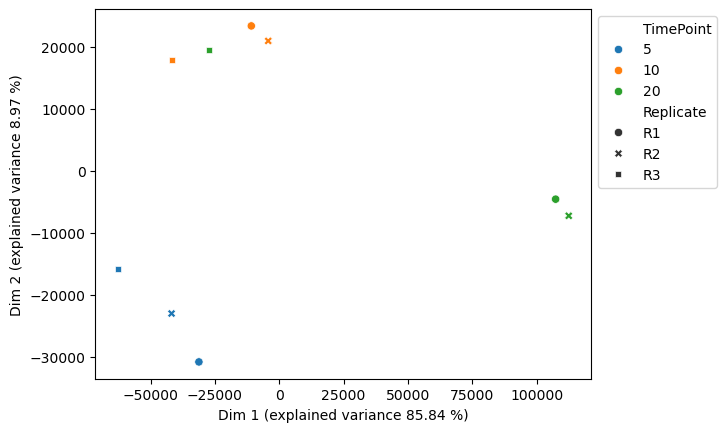

In [20]:
txPCA(tpms[columnOrder])

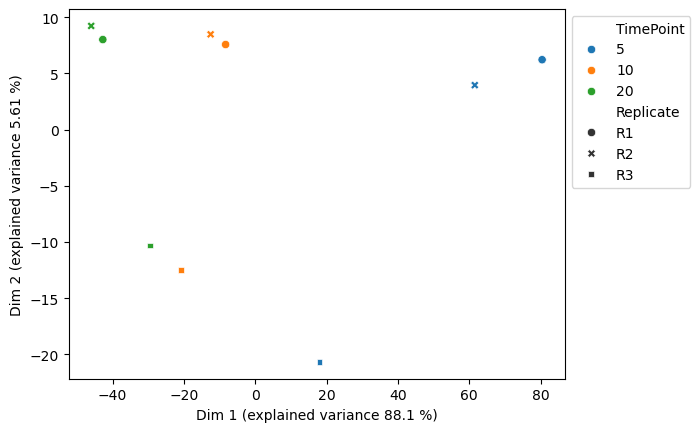

In [21]:
txPCA(logTPMs[columnOrder])

In [22]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

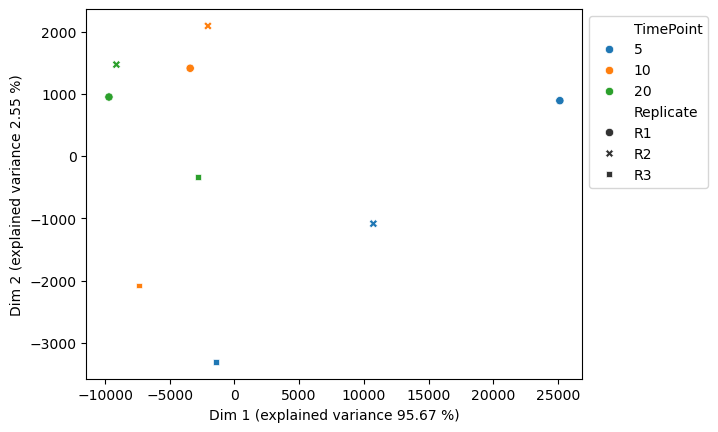

In [23]:
txPCA(tpmHost[columnOrder])

tpmPhage

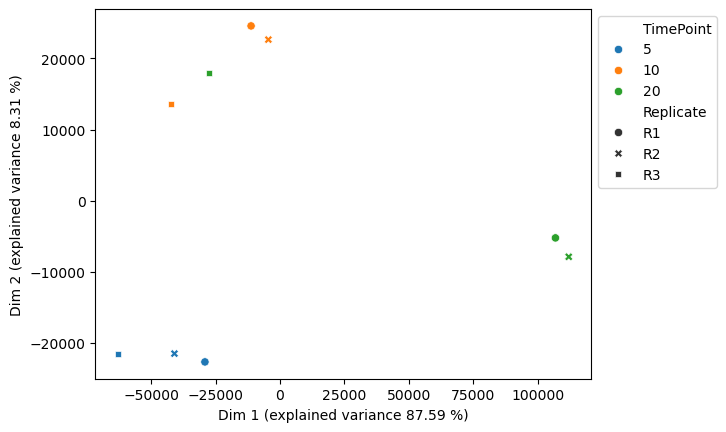

In [24]:
txPCA(tpmPhage[columnOrder])

logTPM Host

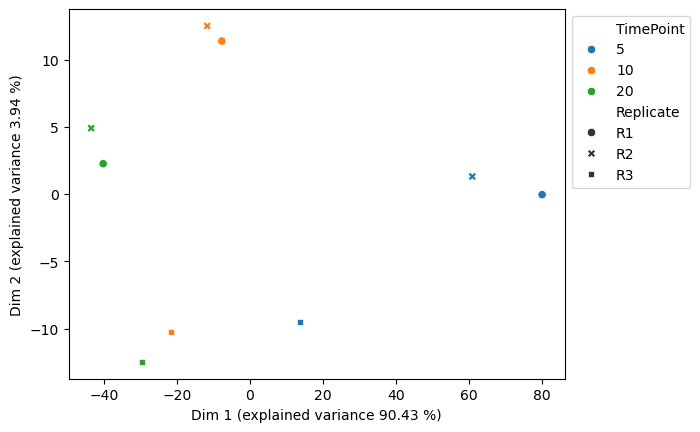

In [25]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

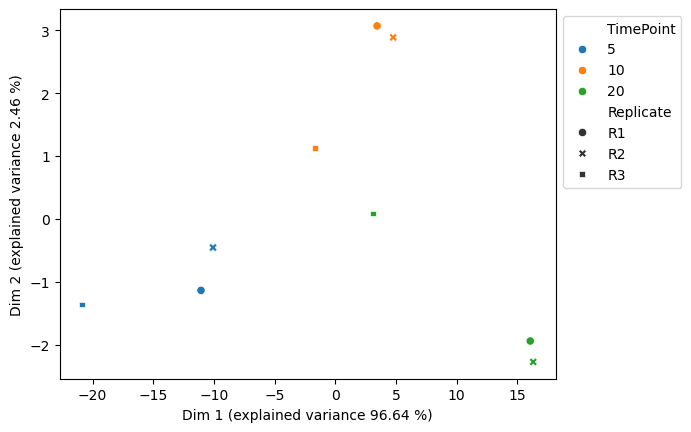

In [26]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Check PCA with removing 20_R3.

## PCA without 20_R3


In [27]:
updatedOrder = ['5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '20_R1', '20_R2']

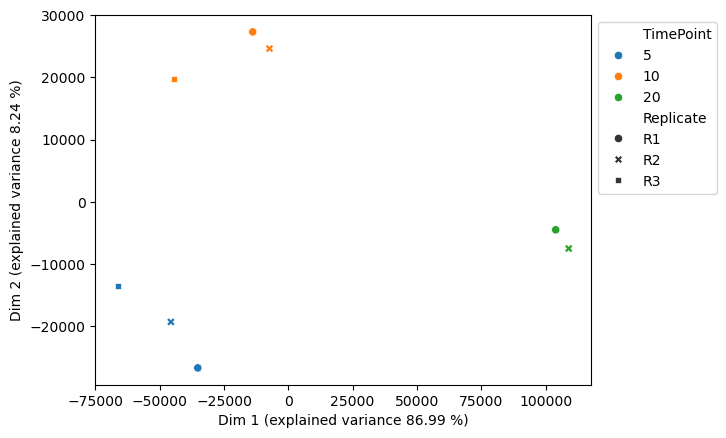

In [28]:
txPCA(tpms[updatedOrder])

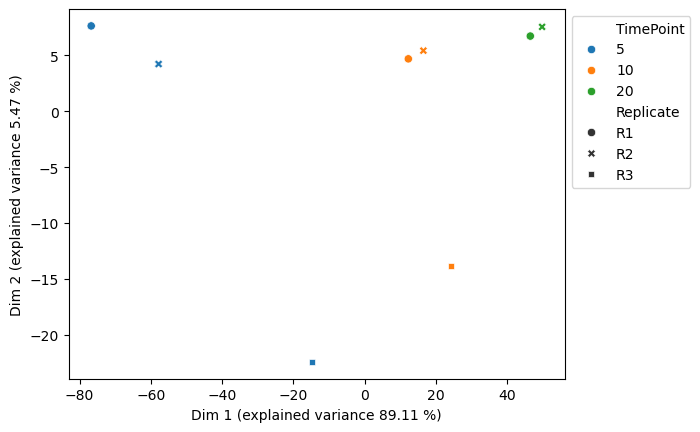

In [29]:
txPCA(logTPMs[updatedOrder])

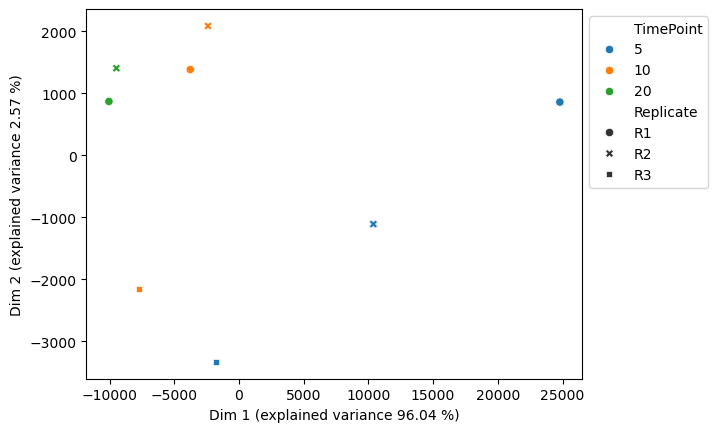

In [30]:
txPCA(tpmHost[updatedOrder])

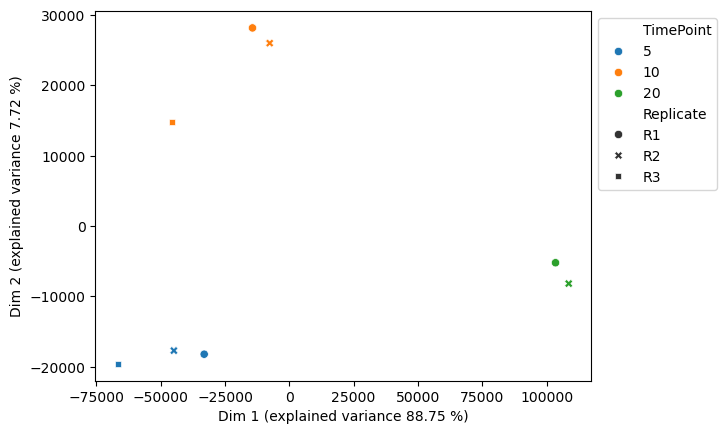

In [31]:
txPCA(tpmPhage[updatedOrder])

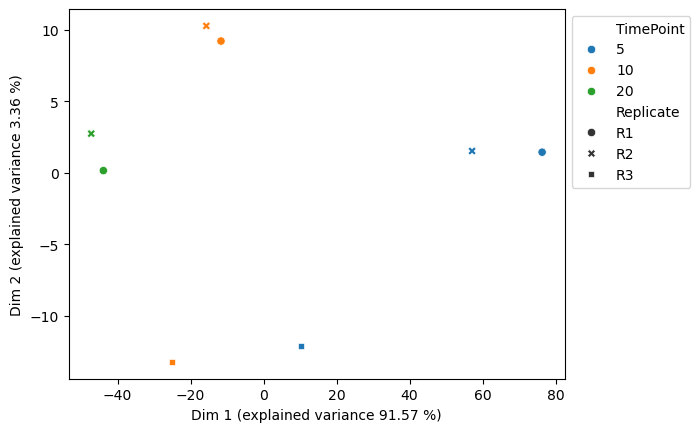

In [32]:
txPCA(logTPMsHost[updatedOrder])

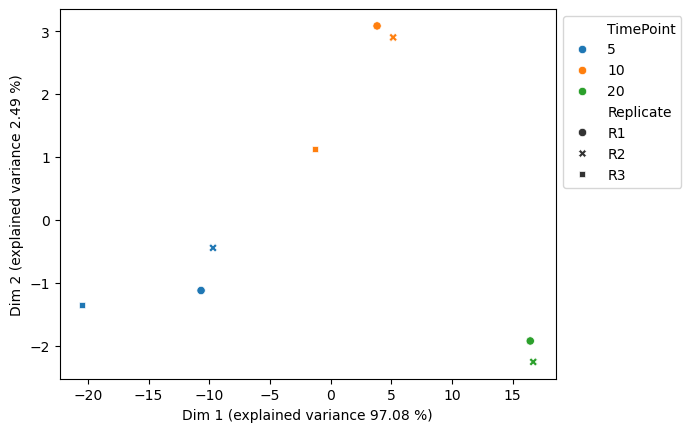

In [33]:
txPCA(logTPMsPhage[updatedOrder])

## PCA with R3 from all timepoints removed

In [34]:
updatedOrderV2 = ['5_R1', '5_R2', '10_R1', '10_R2', '20_R1', '20_R2']

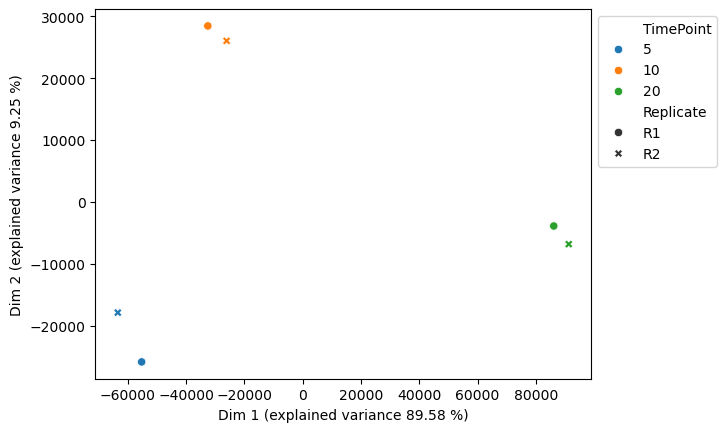

In [35]:
txPCA(tpms[updatedOrderV2])

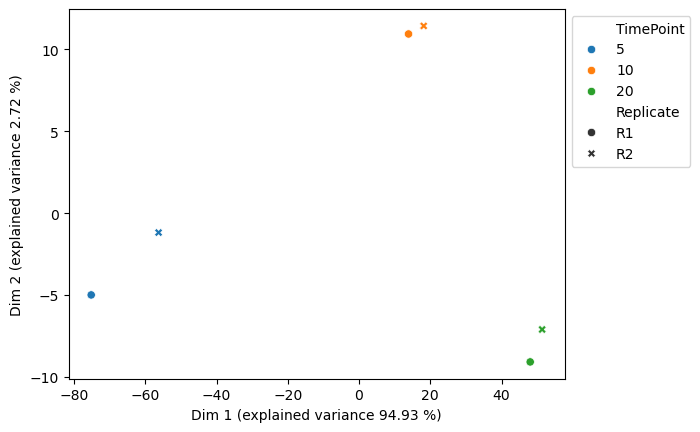

In [36]:
txPCA(logTPMs[updatedOrderV2])

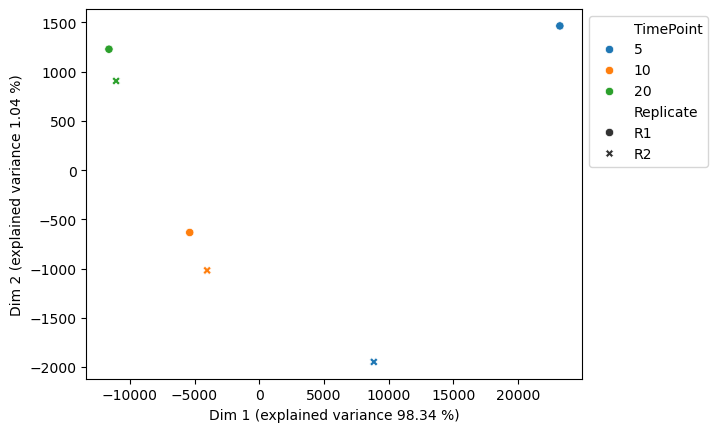

In [37]:
txPCA(tpmHost[updatedOrderV2])

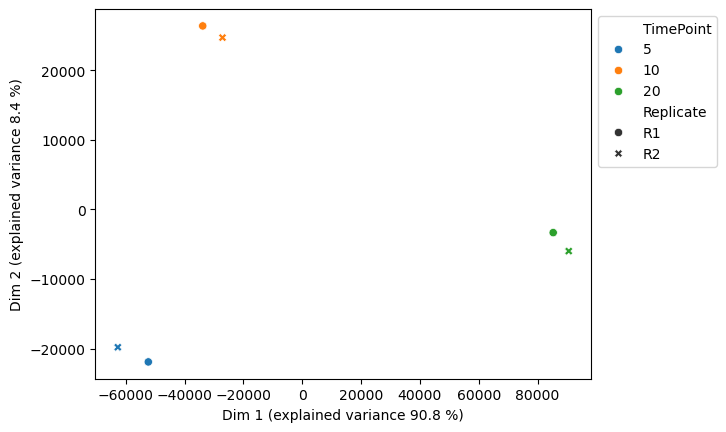

In [38]:
txPCA(tpmPhage[updatedOrderV2])

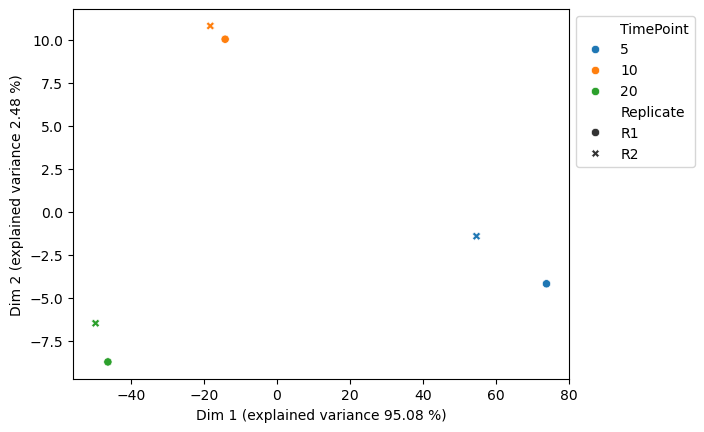

In [39]:
txPCA(logTPMsHost[updatedOrderV2])

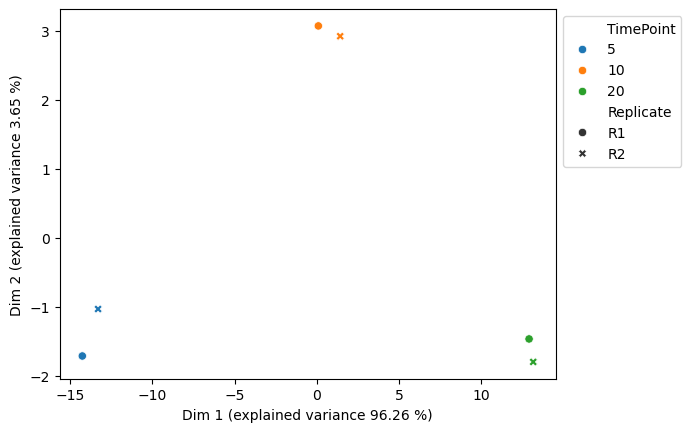

In [40]:
txPCA(logTPMsPhage[updatedOrderV2])

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [41]:
tpmsUpdated = tpms.drop(['5_R3', '10_R3', '20_R3'], axis = 1)

In [42]:
TPMmeans, TPMsds = getMeanSD(tpmsUpdated[updatedOrderV2])
TPMmeans = TPMmeans[['5', '10', '20']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,5,10,20,Entity,Symbol
Geneid,,,,,
gene-AUO97_RS09875,90.796415,21.935746,16.231206,host,gene-AUO97_RS09875
gene-AUO97_RS02075,30.881235,9.243112,3.232693,host,gene-AUO97_RS02075
gene-AUO97_RS09240,95.386410,25.257359,12.128468,host,gene-AUO97_RS09240
gene-AUO97_RS12025,0.246448,0.131326,0.043440,host,gene-AUO97_RS12025
gene-AUO97_RS18955,25.126044,5.729246,3.521169,host,gene-AUO97_RS18955
...,...,...,...,...,...
gene-AUO97_RS14440,19.917175,10.999690,3.149766,host,gene-AUO97_RS14440
gene-AUO97_RS02990,190.254266,67.017802,31.405707,host,gene-AUO97_RS02990
gene-AUO97_RS17825,61.270446,25.848249,5.782840,host,gene-AUO97_RS17825


In [43]:
TPMsds = TPMsds[['5', '10', '20']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,5,10,20,Entity,Symbol
Geneid,,,,,
gene-AUO97_RS09875,13.847932,1.432310,0.579092,host,gene-AUO97_RS09875
gene-AUO97_RS02075,0.588054,0.990371,0.693613,host,gene-AUO97_RS02075
gene-AUO97_RS09240,15.341548,1.111680,1.625911,host,gene-AUO97_RS09240
gene-AUO97_RS12025,0.204308,0.017626,0.004831,host,gene-AUO97_RS12025
gene-AUO97_RS18955,4.384299,1.034536,0.660252,host,gene-AUO97_RS18955
...,...,...,...,...,...
gene-AUO97_RS14440,3.010515,1.646801,0.420815,host,gene-AUO97_RS14440
gene-AUO97_RS02990,26.077621,0.166936,1.734229,host,gene-AUO97_RS02990
gene-AUO97_RS17825,8.473278,1.235644,0.268677,host,gene-AUO97_RS17825


In [44]:
propExp = proportionalExp(TPMmeans[['5', '10', '20']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,5,10,20,Entity,Symbol
Geneid,,,,,
gene-AUO97_RS09875,1.0,0.241593,0.178765,host,gene-AUO97_RS09875
gene-AUO97_RS02075,1.0,0.299312,0.104681,host,gene-AUO97_RS02075
gene-AUO97_RS09240,1.0,0.264790,0.127151,host,gene-AUO97_RS09240
gene-AUO97_RS12025,1.0,0.532875,0.176266,host,gene-AUO97_RS12025
gene-AUO97_RS18955,1.0,0.228020,0.140140,host,gene-AUO97_RS18955
...,...,...,...,...,...
gene-AUO97_RS14440,1.0,0.552272,0.158143,host,gene-AUO97_RS14440
gene-AUO97_RS02990,1.0,0.352254,0.165072,host,gene-AUO97_RS02990
gene-AUO97_RS17825,1.0,0.421871,0.094382,host,gene-AUO97_RS17825


## 5. Phage gene classification

In [45]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [46]:
# # Export fractional expressions with T=0.6 + Host/Phage Annotation for Orthofinder Analysis
# t = classLabelThreshold(propExp)
# t = t[t["Entity"] == "phage"]
# t["Host"] = "Acinetobacter_baumannii_ATCC_17978"
# t["Phage"] = "Acinetobacter_phage_Abp1"
# t.to_csv("/ceph/ibmi/studenten/waffen/Cross_Analysis/Orthofinder_Clustering/Fractional_Expressions/T060/Yang_fractional_expression_T=0.6.tsv", sep="\t")

In [47]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [48]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [49]:
TPMmeans

,5,10,20,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,
gene-AUO97_RS09875,90.796415,21.935746,16.231206,host,gene-AUO97_RS09875,None,None
gene-AUO97_RS02075,30.881235,9.243112,3.232693,host,gene-AUO97_RS02075,None,None
gene-AUO97_RS09240,95.386410,25.257359,12.128468,host,gene-AUO97_RS09240,None,None
gene-AUO97_RS12025,0.246448,0.131326,0.043440,host,gene-AUO97_RS12025,None,None
gene-AUO97_RS18955,25.126044,5.729246,3.521169,host,gene-AUO97_RS18955,None,None
...,...,...,...,...,...,...,...
gene-AUO97_RS14440,19.917175,10.999690,3.149766,host,gene-AUO97_RS14440,None,None
gene-AUO97_RS02990,190.254266,67.017802,31.405707,host,gene-AUO97_RS02990,None,None
gene-AUO97_RS17825,61.270446,25.848249,5.782840,host,gene-AUO97_RS17825,None,None


In [50]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      28
middle    17
early      9
Name: count, dtype: int64

Add classes to other dfs.

In [51]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpmsUpdated[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NZ_CP018664.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_021316.1']
gff3_genes["seq_id"].unique()

array(['NZ_CP018664.1', 'NC_021316.1'], dtype=object)

## 6. Add variance to all dataframes

Base variance call on tpms.

In [52]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [53]:
tpmsUpdated = stabilizedVariance(tpmsUpdated)
tpmsUpdated

SampleNames,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,
gene-AUO97_RS09875,104.644346,76.948483,23.368055,20.503436,15.652114,16.810298,host,gene-AUO97_RS09875,None,None,28.216695
gene-AUO97_RS02075,30.293181,31.469290,10.233483,8.252741,3.926306,2.539080,host,gene-AUO97_RS02075,None,None,9.796169
gene-AUO97_RS09240,110.727958,80.044862,26.369039,24.145678,13.754378,10.502557,host,gene-AUO97_RS09240,None,None,31.984759
gene-AUO97_RS12025,0.042140,0.450755,0.113700,0.148952,0.038609,0.048271,host,gene-AUO97_RS12025,None,None,0.149105
gene-AUO97_RS18955,29.510343,20.741745,6.763781,4.694710,2.860917,4.181421,host,gene-AUO97_RS18955,None,None,8.824516
...,...,...,...,...,...,...,...,...,...,...,...
gene-AUO97_RS14440,22.927690,16.906660,12.646491,9.352889,2.728952,3.570581,host,gene-AUO97_RS14440,None,None,4.482838
gene-AUO97_RS02990,216.331886,164.176645,67.184739,66.850866,29.671478,33.139937,host,gene-AUO97_RS02990,None,None,50.503305
gene-AUO97_RS17825,69.743724,52.797169,27.083893,24.612605,6.051516,5.514163,host,gene-AUO97_RS17825,None,None,17.783752


In [54]:
TPMmeans['Variance'] = tpmsUpdated['Variance']
TPMsds['Variance'] = tpmsUpdated['Variance']
propExp['Variance'] = tpmsUpdated['Variance']

## 7. Write data to output

In [55]:
df_norRNAs[['Entity', 'Symbol']] = tpmsUpdated[['Entity', 'Symbol']]
df_norRNAsUpdated = df_norRNAs.drop(['5_R3', '10_R3', '20_R3'], axis = 1)

In [56]:
# Full TPM table
tpmsUpdated.to_csv('Yang_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAsUpdated.to_csv('Yang_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Yang_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Yang_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Yang_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Yang_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Yang_phage_gff3.tsv', sep='\t')